<div><img src="https://www.ibm.com/blogs/bluemix/wp-content/uploads/2015/09/iot-service-card-1024x512.png
", width=400, height=400, align = 'right'> 
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png", width = 90, height = 90, align = 'right', style="margin:0px 25px"></div>

# Predicting Machine Failure: 
## Exploring Device Data from Watson IoT Platform

_______________________
In this notebook we load data from Db2 Warehouse on Cloud into R and explore it visually and statisically.  Any anomalous data points will be labeled, a useful preprocessing step for machine learning.

##### Table of Contents

1. Load Data
2. Join Tables
3. Reshape & Explore
 - Summary Stats
 - Visualization
4. Pre-processing for Machine Learning
5. Conclusion
____________________

##### Load Data from IBM Cloud Object Storage

Use the _insert to code_ feature in the code cell below.

In [4]:
if (!suppressWarnings(require(ibmos2sparkR, quiet=TRUE) && (packageVersion(pkg = "ibmos2sparkR") == '0.0.9'))) {
    library(devtools)
    devtools::install_url("https://github.com/ibm-watson-data-lab/ibmos2spark/archive/1.0.2.zip", subdir= "r/sparkr/", quiet=TRUE)
}
library(ibmos2sparkR)
# @hidden_cell
credentials <- list(
    endpoint = "https://s3-api.us-geo.objectstorage.service.networklayer.com",
    serviceId = "iam-ServiceId-55a28231-93f5-4a4e-a41b-da02d7475bdb",
    iamServiceEndpoint = "https://iam.bluemix.net/oidc/token",
    apiKey = "k8VQmGIFXZAFurLLGRmtl1iTSoTVR1wsjT8I9v0T5ij3")

configurationName <- "os_7806db70f37b4c06a00800925c962925_configs"
cos <- CloudObjectStorage(sparkContext=sc, credentials=credentials, configurationName=configurationName, cosType="bluemix_cos")

invisible(sparkR.session(appName = "SparkSession R"))

df.data.3 <- read.df(
    cos$url("wspredictivemaintenance-donotdelete-pr-4abxmqkuz2q18l", "data_asset/Clean+Raw+Sensor+Data+-+Complete_3n7te3PtRqOIpA5fihea_A.csv"),
    source = "org.apache.spark.sql.execution.datasources.csv.CSVFileFormat",
    header = "true")
head(df.data.3)


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190312182903-0000
KERNEL_ID = 4b0828ac-8e90-40b0-9cfa-486d09b52995


temperature,temp_scale,PSI,flow_rate_LFM,geophone,geophone_scale,accelerometer,accel_scale,sensor_type,well_id,⋯,timestamp,temperature_ celsius,LATITUDE,LONGITUDE,FIELD_ID,ROCK_FORMATION,ROCK_CLASSIFICATION,ROCK_DENSITY,AVG_DAILY_OUTPUT,LAST_MAINTENANCE
216.28352621279,Fahrenheit,3310.92918853309,0.591641222789166,63.1752400541945,V/m,5.86599545717316,G,asset0,AK_NS006a,,2017-11-03 21:29:45,102.37973678488333,70.2556322004100000,148.3387574452710000,NS Borealis,Porous,Brittle,high,medium,2017-09-30
209.416350418658,Fahrenheit,3217.9068168436,0.539325270457485,67.6781561084775,V/m,7.18667497867905,G,asset0,AK_NS006a,,2017-11-03 21:29:50,98.56463912147666,70.2556322004100000,148.3387574452710000,NS Borealis,Porous,Brittle,high,medium,2017-09-30
213.65183275373,Fahrenheit,3266.56052520574,0.428861419325876,66.5512955715468,V/m,7.99332908968516,G,asset0,AK_NS006a,,2017-11-03 21:29:55,100.91768486318333,70.2556322004100000,148.3387574452710000,NS Borealis,Porous,Brittle,high,medium,2017-09-30
212.227221535139,Fahrenheit,3304.53865252359,0.569195934648405,65.6489106783482,V/m,7.30093715636728,G,asset0,AK_NS006a,,2017-11-03 21:30:00,100.12623418618833,70.2556322004100000,148.3387574452710000,NS Borealis,Porous,Brittle,high,medium,2017-09-30
206.878309519033,Fahrenheit,3214.83954913697,0.602665863234114,68.886057517626,V/m,7.08397207434568,G,asset0,AK_NS006a,,2017-11-03 21:30:05,97.15461639946277,70.2556322004100000,148.3387574452710000,NS Borealis,Porous,Brittle,high,medium,2017-09-30
219.21655649447,Fahrenheit,3190.6984426699,0.540232181122567,66.5108586028596,V/m,8.76324998736362,G,asset0,AK_NS006a,,2017-11-03 21:30:10,104.00919805248334,70.2556322004100000,148.3387574452710000,NS Borealis,Porous,Brittle,high,medium,2017-09-30


____________

#### Load Libraries
Now load the open source libraries needed to explore the data.

In [1]:
## Load libraries
suppressWarnings(suppressMessages(install.packages('zoo')))
suppressWarnings(suppressMessages(library(dplyr)))
suppressWarnings(suppressMessages(library(zoo)))
suppressWarnings(suppressMessages(library(ggplot2)))

In [5]:
## Convert from Spark DataFrame to regular R dataframe.
sensorsAllDF <- df.data.3 %>% SparkR::collect()

This table describes the asset locations, the characteristics of their environment, as well as readings for a variety of sensor values taken every 5 seconds.  The physical properties being detected are:

> _Temperature_
>
> _Pressure_
>
> _Geophone (seismic activity)_
>
> _Flow Rate_
>
> _Accelerometer (changes in acceleration)_

Let's convert the timestamp column to Datetime, then look at the summary statistics for each of the columns.

In [6]:
## Clean up data types
colnames(sensorsAllDF) <- toupper(colnames(sensorsAllDF))
toNumeric <- c("TEMPERATURE", "PSI", "GEOPHONE", "FLOW_RATE_LFM", "ACCELEROMETER", "LONGITUDE", "LATITUDE")
toFactor <- c("FIELD_ID", "ROCK_FORMATION", "ROCK_CLASSIFICATION", "AVG_DAILY_OUTPUT")
sensorsAllDF[, toNumeric] <- apply(sensorsAllDF[, toNumeric], 2, as.numeric)
sensorsAllDF[, toFactor] <- apply(sensorsAllDF[, toFactor], 2, as.factor)
sensorsAllDF$TIMESTAMP <- as.POSIXct(strptime(sensorsAllDF$TIMESTAMP, "%Y-%m-%d %H:%M:%S"))

## View summary
summary(sensorsAllDF)

  TEMPERATURE     TEMP_SCALE             PSI       FLOW_RATE_LFM   
 Min.   :180.8   Length:180000      Min.   :2796   Min.   :0.2457  
 1st Qu.:206.4   Class :character   1st Qu.:3000   1st Qu.:0.5530  
 Median :211.0   Mode  :character   Median :3099   Median :0.6399  
 Mean   :211.0                      Mean   :3125   Mean   :0.6235  
 3rd Qu.:215.6                      3rd Qu.:3250   3rd Qu.:0.6982  
 Max.   :263.2                      Max.   :3484   Max.   :0.9288  
    GEOPHONE     GEOPHONE_SCALE     ACCELEROMETER     ACCEL_SCALE       
 Min.   :33.72   Length:180000      Min.   : 0.2554   Length:180000     
 1st Qu.:49.99   Class :character   1st Qu.: 4.9810   Class :character  
 Median :60.29   Mode  :character   Median : 6.1892   Mode  :character  
 Mean   :58.99                      Mean   : 6.3463                     
 3rd Qu.:68.00                      3rd Qu.: 7.7053                     
 Max.   :78.02                      Max.   :12.5412                     
 SENSOR_TYPE 

Taking a close look at the quantiles for numeric data we can definitely see something out of the ordinary with the accelerometer.  **What's happening where the values are so close to zero?**

As a next step let's look at the cases where values are at the extremes for each variable.  We can subset the data by quantiles to find the rows with extreme values. Once we know those values we should be able to isolate the sensors causing any anomalies.

#### Identify Outliers

In [7]:
## Identify max and min quantile values for numeric data
extremes <- apply(sensorsAllDF[, toNumeric], 2, quantile)[c(1, 5), c(1:5)] %>% as.data.frame()
extremes

,TEMPERATURE,PSI,GEOPHONE,FLOW_RATE_LFM,ACCELEROMETER
0%,180.8257,2795.526,33.71570,0.2457207,0.2554244
100%,263.1948,3484.356,78.01914,0.9288156,12.5411913


#### Filter for potentially anomalous sensor activity
Using the data frame of extreme values above, we can now filter our data set to isolate which sensors are responsible for generating them.

In [8]:
## Isolate sensors which extreme values.
anomalousDF <- filter(sensorsAllDF,
                      TEMPERATURE %in% extremes[, "TEMPERATURE"] |
                      PSI %in% extremes[, "PSI"] |
                      GEOPHONE %in% extremes[, "GEOPHONE"] |
                      ACCELEROMETER %in% extremes[, "ACCELEROMETER"] |
                      FLOW_RATE_LFM %in% extremes[, "FLOW_RATE_LFM"]
                     )

anomalousDF

TEMPERATURE,TEMP_SCALE,PSI,FLOW_RATE_LFM,GEOPHONE,GEOPHONE_SCALE,ACCELEROMETER,ACCEL_SCALE,SENSOR_TYPE,WELL_ID,⋯,TIMESTAMP,TEMPERATURE_ CELSIUS,LATITUDE,LONGITUDE,FIELD_ID,ROCK_FORMATION,ROCK_CLASSIFICATION,ROCK_DENSITY,AVG_DAILY_OUTPUT,LAST_MAINTENANCE
263.1948,Fahrenheit,3457.637,0.6454289,72.31116,V/m,10.1517259,G,asset0,AK_PB001a,,2017-11-03 19:22:25,128.4415460210789,70.25560,148.3385,Prudhoe Bay,Non-porous,Capped,medium,high,2017-11-02
247.7565,Fahrenheit,3484.356,0.5054840,76.64474,V/m,6.6980344,G,asset0,AK_PB001a,,2017-11-03 19:22:50,119.86472311235777,70.25560,148.3385,Prudhoe Bay,Non-porous,Capped,medium,high,2017-11-02
180.8257,Fahrenheit,2795.526,0.3638966,55.22617,V/m,5.8907313,G,asset0,AK_NS005a,,2017-11-03 13:09:40,82.68097095507444,70.25562,148.3383,NS Borealis,Non-porous,Capped,high,low,2017-10-19
218.6871,Fahrenheit,3206.523,0.3915633,78.01914,V/m,8.3556178,G,asset0,AK_PB002b,,2017-11-03 19:36:00,103.71505571001555,70.25564,148.3385,Prudhoe Bay,Non-porous,Capped,high,high,2017-09-28
216.2577,Fahrenheit,3203.671,0.2457207,67.58727,V/m,7.5923476,G,asset0,AK_NS002c,,2017-11-03 14:13:10,102.36541233467777,70.25559,148.3384,NS Borealis,Non-porous,Brittle,high,low,2017-09-20
209.0130,Fahrenheit,3227.987,0.5578293,67.54707,V/m,12.5411913,G,asset0,AK_NS006c,,2017-11-03 14:15:05,98.34055472447554,70.25562,148.3386,NS Borealis,Porous,Non-Capped,medium,low,2017-09-23
217.0507,Fahrenheit,3241.233,0.9288156,68.36256,V/m,7.8692371,G,asset0,AK_PB003c,,2017-11-03 21:50:35,102.80595675740668,70.25557,148.3383,Prudhoe Bay,Non-porous,Capped,low,medium,2017-09-12
222.1819,Fahrenheit,3330.166,0.4192950,67.63989,V/m,0.2554244,G,asset0,AK_NS004b,,2017-11-03 20:33:45,105.65660842642612,70.25555,148.3384,NS Borealis,Porous,Brittle,medium,low,2017-10-27
218.6486,Fahrenheit,2993.402,0.7060093,33.71570,V/m,4.8438995,G,asset1,AK_NS004c,,2017-11-03 21:41:15,103.69366555473944,70.25569,148.3383,NS Borealis,Non-porous,Brittle,low,medium,2017-10-12


#### Data Visualization

Perhaps the quickest way to see what's going on with these sensors is to plot some of their values over time and compare the activity.  Hopefully anything out of the ordinary jumps out.

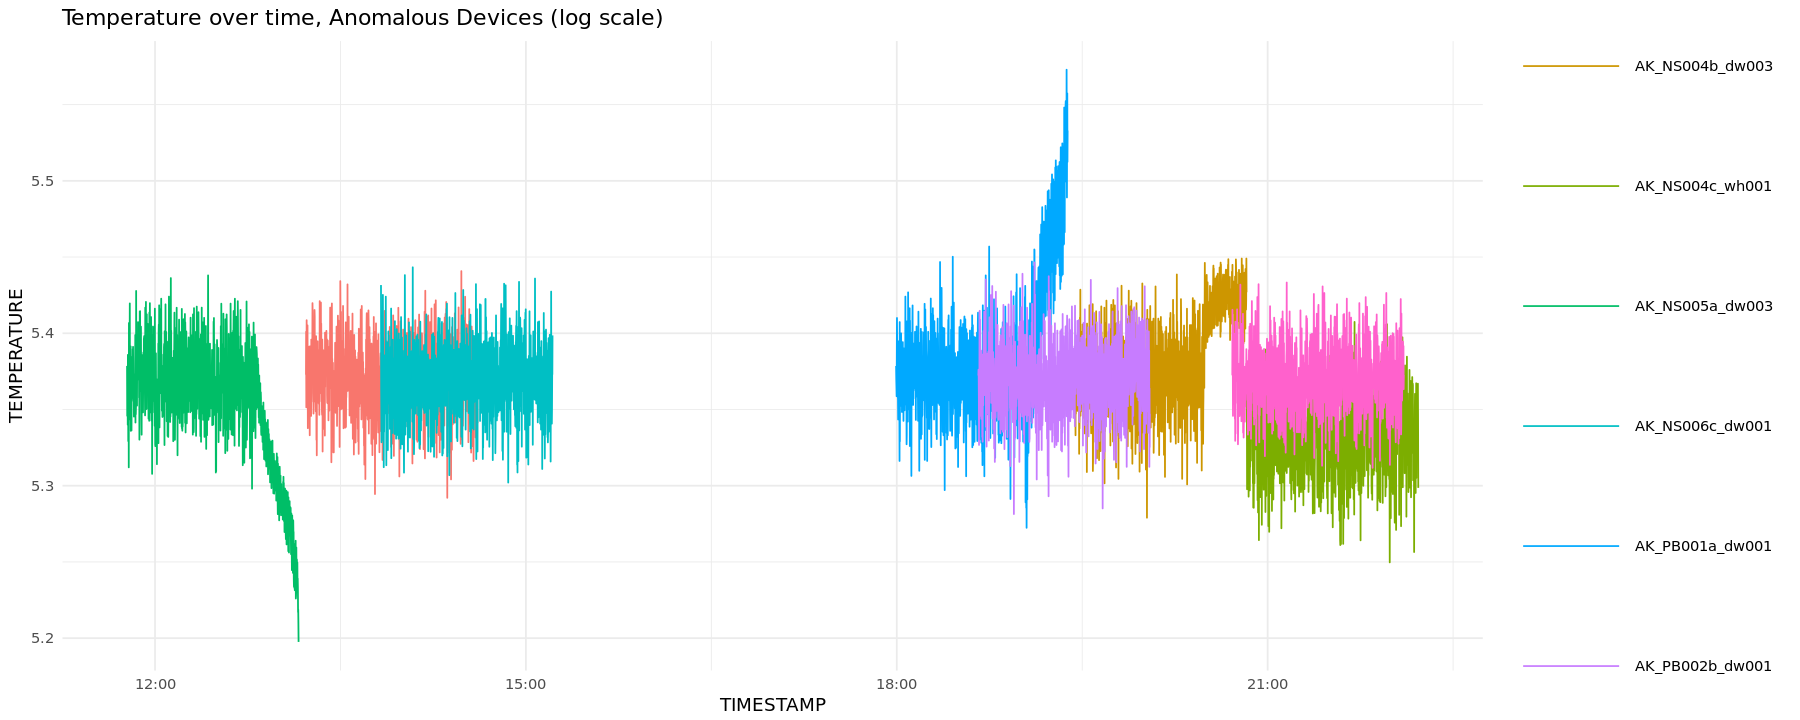

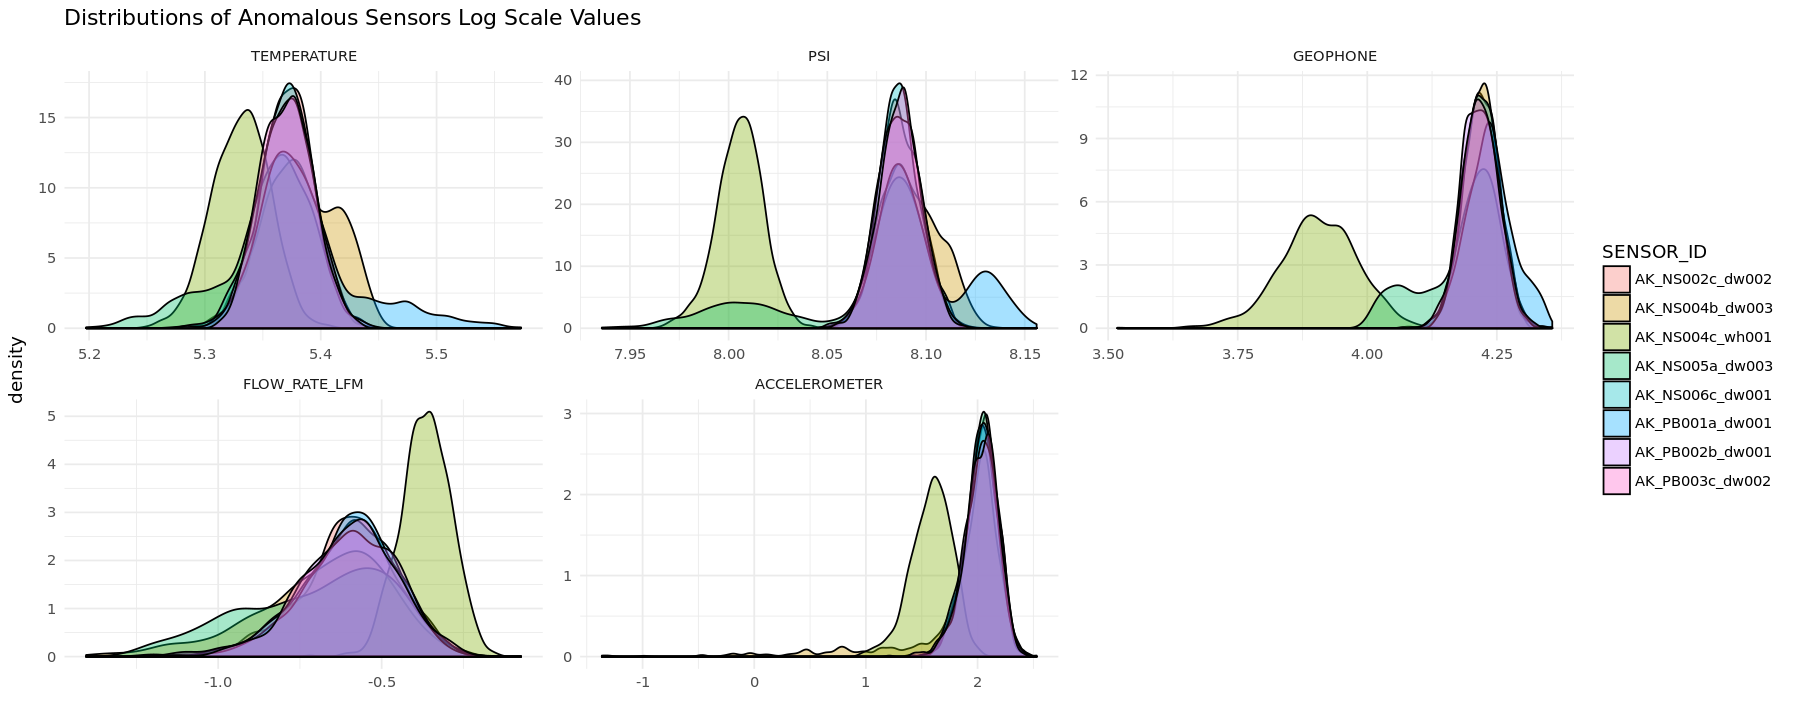

In [9]:
## Grab all rows for sensor IDs with anomalous values
plotDF <- select(sensorsAllDF, one_of(c("SENSOR_ID", "TIMESTAMP", toNumeric))) %>%
            filter(SENSOR_ID %in% anomalousDF$SENSOR_ID)

options(repr.plot.width=15, repr.plot.height=6)
p <- ggplot(plotDF, aes(x = TIMESTAMP, y = log(TEMPERATURE), color = SENSOR_ID)) + geom_line() + theme_minimal() + 
        labs(title = "Temperature over time, Anomalous Devices (log scale)", y = "TEMPERATURE") + theme(legend.key.size = unit(5,"line")) 
p

## Take a look at distribution across variables for a couple of these sensors
p2 <- select(plotDF, -TIMESTAMP, -LONGITUDE, -LATITUDE) %>% 
        filter(SENSOR_ID %in% anomalousDF$SENSOR_ID) %>%
        reshape2::melt("SENSOR_ID")

ggplot(p2, aes(x = log(value))) +
    geom_density(aes(fill = SENSOR_ID), alpha = 0.35) +
    facet_wrap( ~ variable, scales="free") + 
    theme_minimal() + 
    labs(title = "Distributions of Anomalous Sensors Log Scale Values", x = "")

These views allow us to identify which of the sensors possess runaway or anomalous values.  Let's subset the data for these sensors and take a look at what's going on more closely.

The following charts take each of the suspect sensors and view their values as a time series.  So for sensor __'AK_PB001a_dw001'__ you'll see the values recorded for temperature, PSI, geophone, and so on.  The next chart will be the same for the next sensor, and so on.  

While inspecting the charts, try to imagine the cases that would produce values like these.

`geom_smooth()` using method = 'gam'


`geom_smooth()` using method = 'gam'


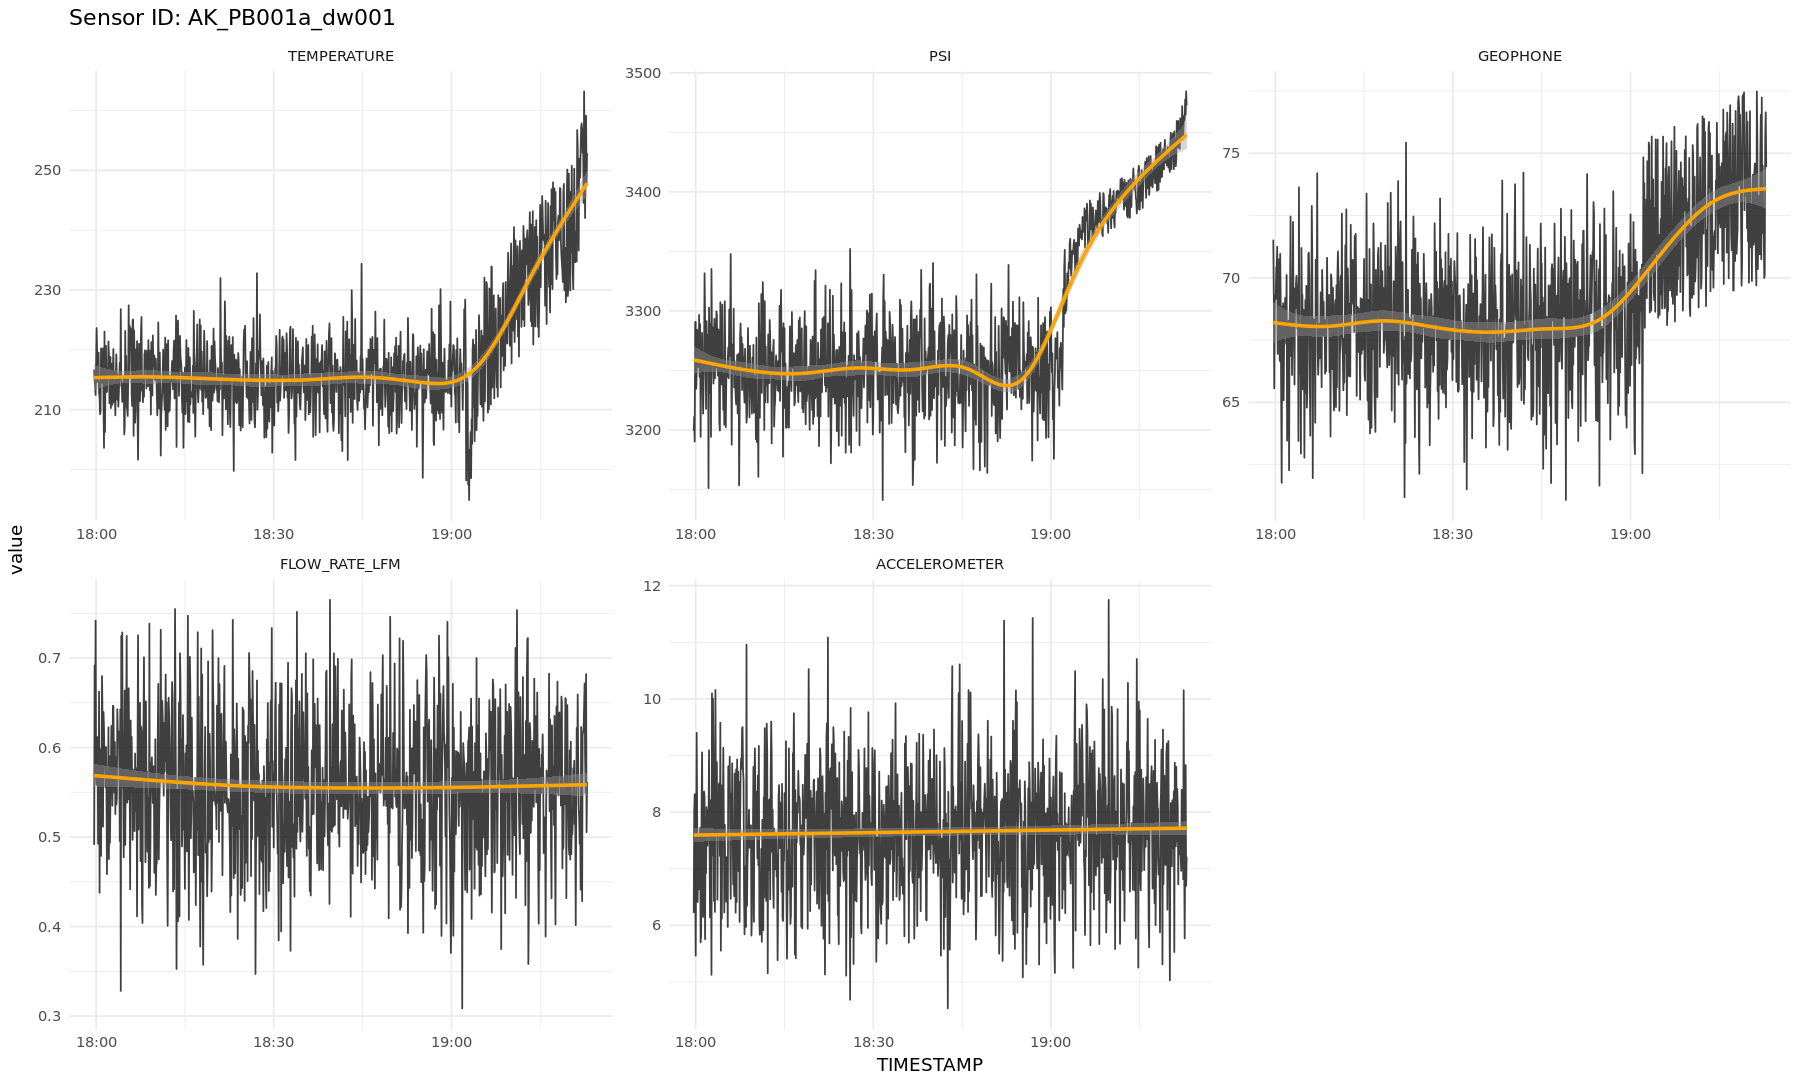

`geom_smooth()` using method = 'gam'


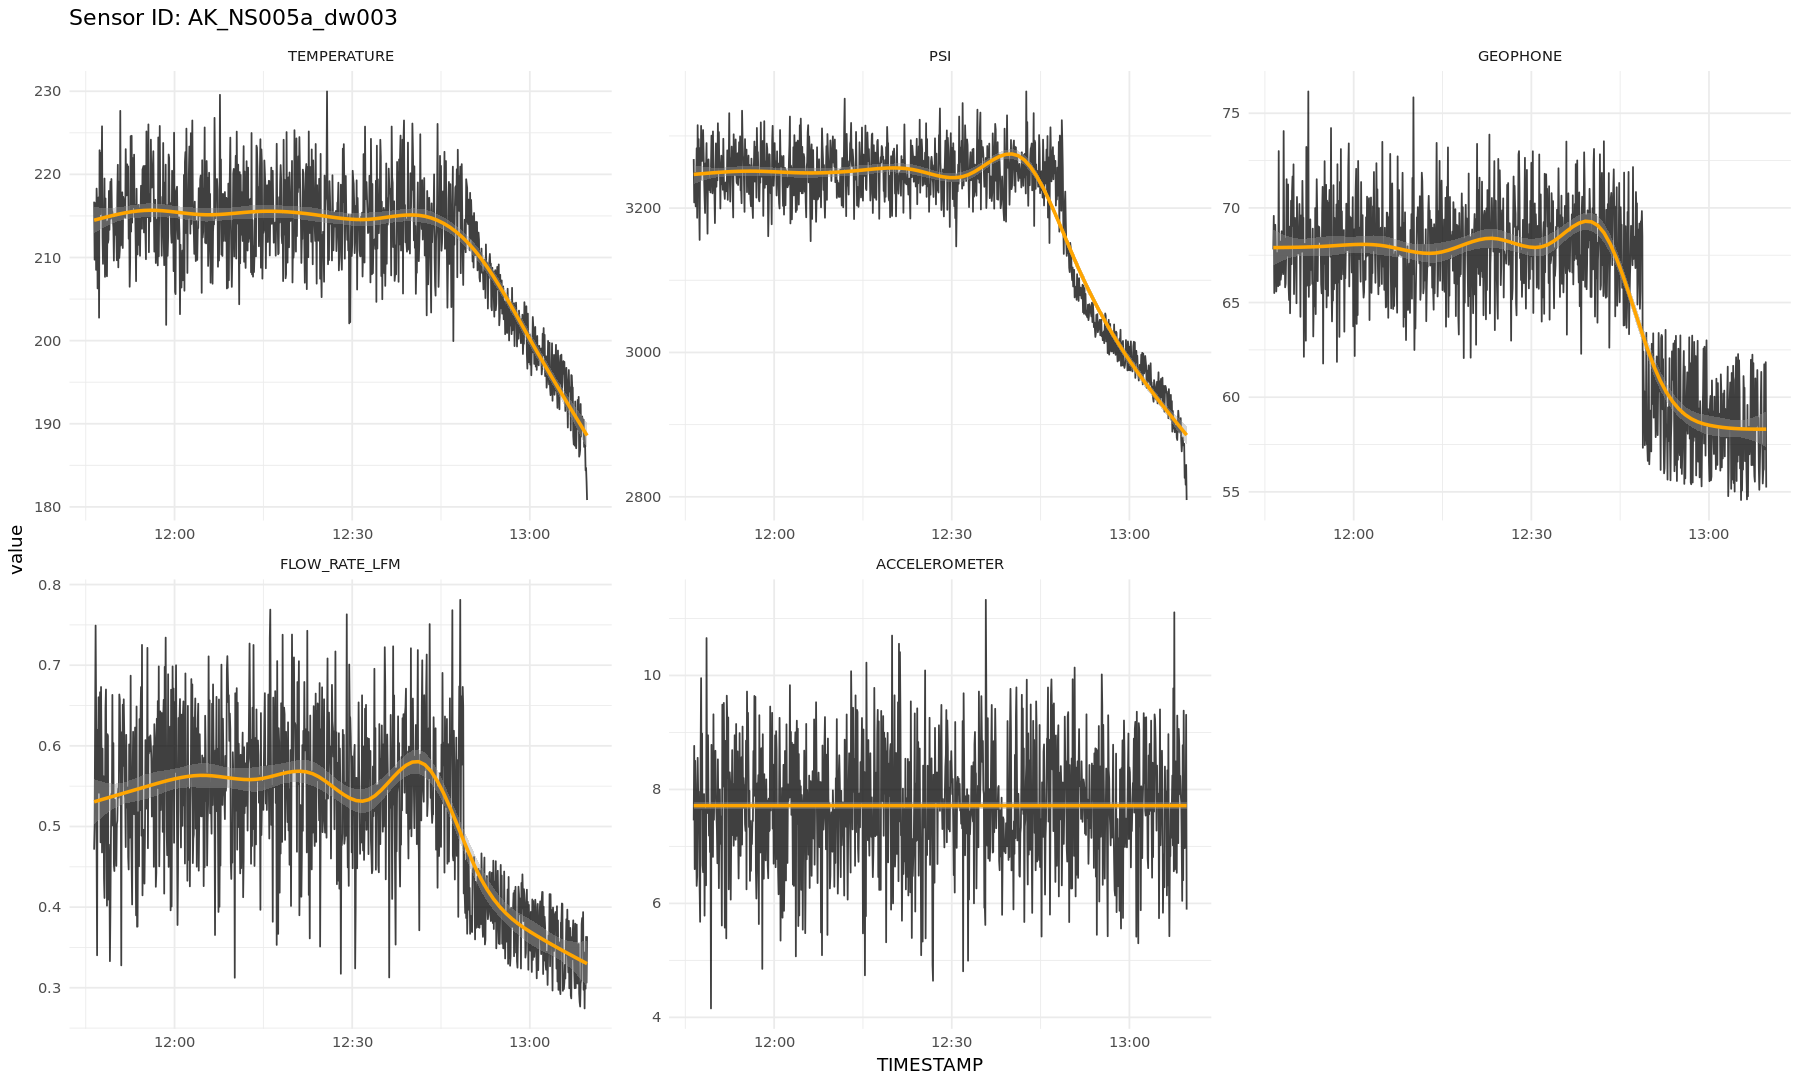

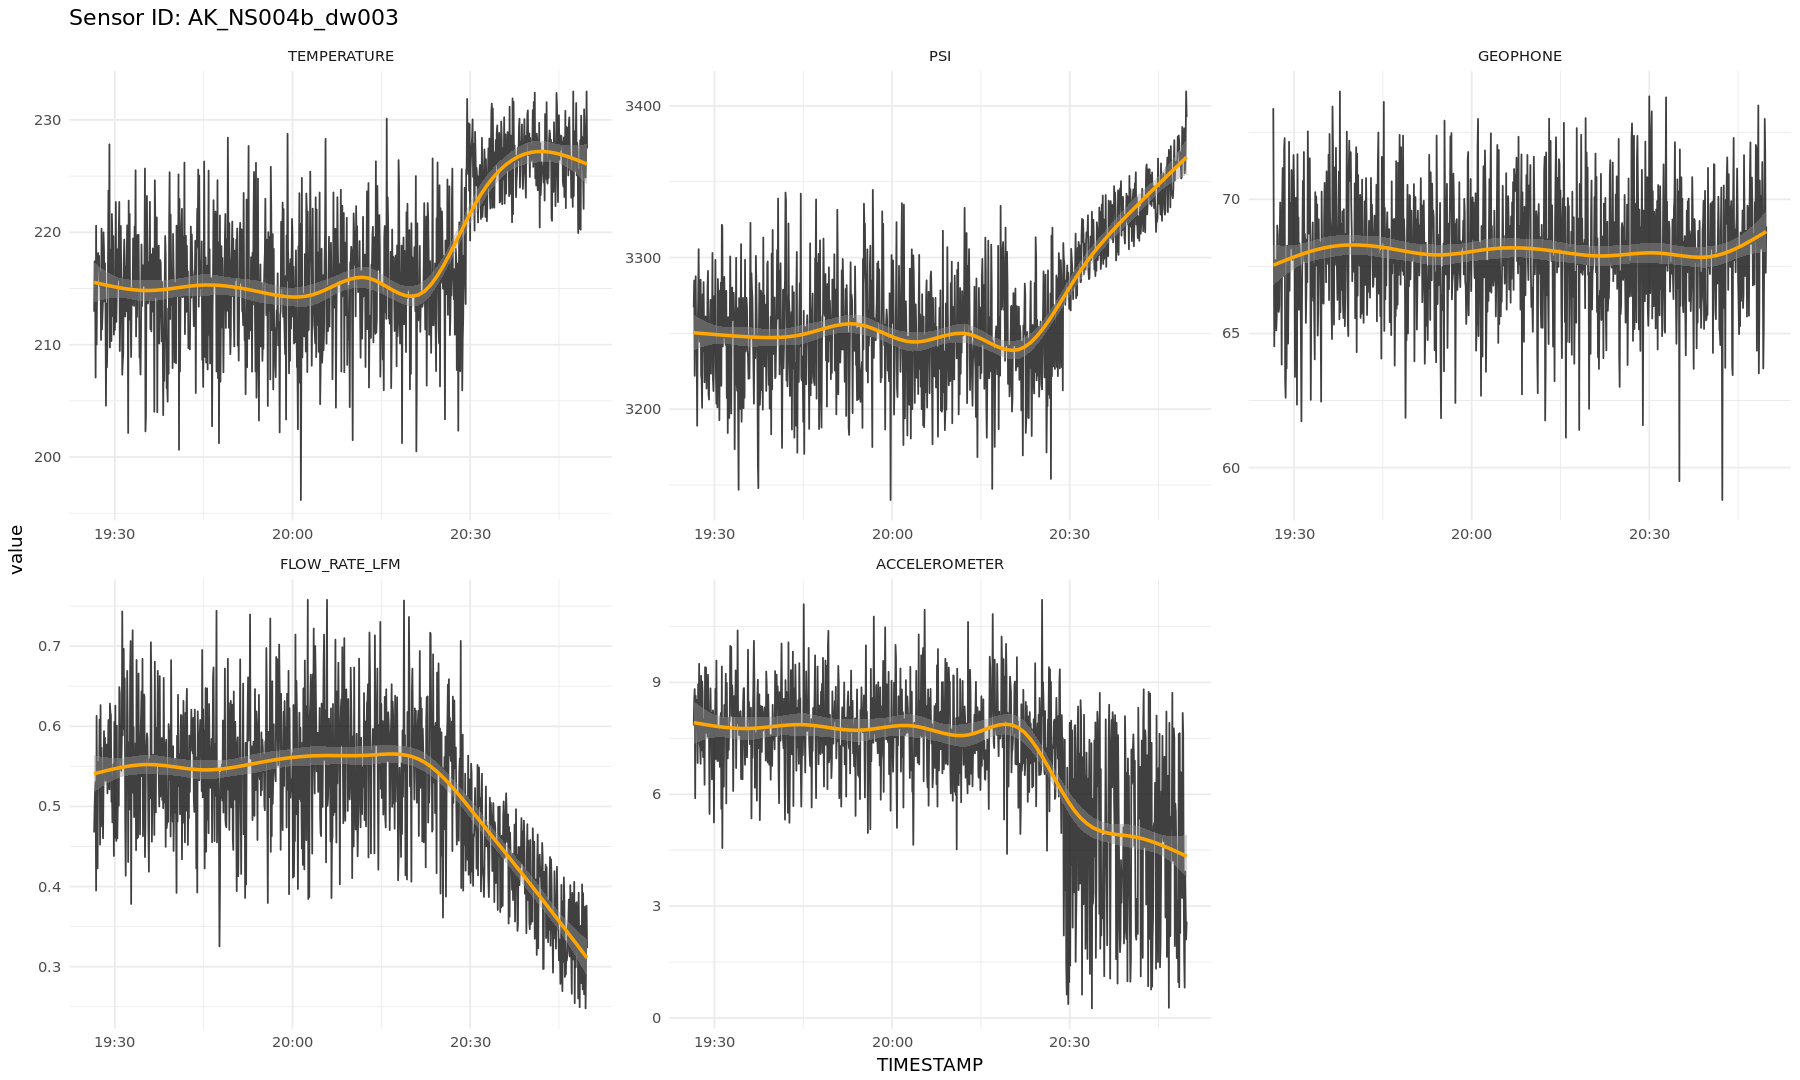

In [10]:
## Visualize time series for sensors, split by variable (facet grid)
options(repr.plot.width=15, repr.plot.height=9)

## AK_PB001a_dw001
p3 <- select(plotDF, -LONGITUDE, -LATITUDE, TIMESTAMP) %>%
        filter(SENSOR_ID == "AK_PB001a_dw001") %>%
        reshape2::melt(id.vars = c("TIMESTAMP", "SENSOR_ID"))

ggplot(p3, aes(x = TIMESTAMP, y = value)) + 
    geom_line(alpha = 0.75) +
    suppressMessages(geom_smooth(color = 'orange')) + 
    facet_wrap( ~ variable, scales = 'free') +
    theme_minimal() +
    labs(title = "Sensor ID: AK_PB001a_dw001")

## AK_NS005a_dw003
p4 <- select(plotDF, -LONGITUDE, -LATITUDE, TIMESTAMP) %>%
        filter(SENSOR_ID == "AK_NS005a_dw003") %>%
        reshape2::melt(id.vars = c("TIMESTAMP", "SENSOR_ID"))

ggplot(p4, aes(x = TIMESTAMP, y = value)) + 
    geom_line(alpha = 0.75) +
    suppressMessages(geom_smooth(color = 'orange')) + 
    facet_wrap( ~ variable, scales = 'free') +
    theme_minimal() + 
    labs(title = "Sensor ID: AK_NS005a_dw003")

## AK_NS004b_dw003
p5 <- select(plotDF, -LONGITUDE, -LATITUDE, TIMESTAMP) %>%
        filter(SENSOR_ID == "AK_NS004b_dw003") %>%
        reshape2::melt(id.vars = c("TIMESTAMP", "SENSOR_ID"))

ggplot(p5, aes(x = TIMESTAMP, y = value)) + 
    geom_line(alpha = 0.75) +
    suppressMessages(geom_smooth(color = 'orange')) + 
    facet_wrap( ~ variable, scales = 'free') +
    theme_minimal() + 
    labs(title = "Sensor ID: AK_NS004b_dw003")

Some very striking patterns emerge for these devices.  We may conclude that rising pressure and psi constitutes a potentially dangerous situation, that a sudden drop in sensor values may be associated with sensor failure, and that a decline in flow rate accompanied by a slow build in temperature and pressure is a partial blockage of some sort.

____________________________

### Pre-processing for Machine Learning
#### Assigning Labels to Device Data

We want to start moving towards training a supervised machine learning model, and to do so requires classifying our data points.  Though we have an idea of how we want to classify them - danger, sensor failure, and partial blockage - we would do well to further prepare the data and remove any columns that aren't useful.

In [11]:
## Filter for anomalous sensors and create label column
trainingDF <- select(sensorsAllDF, one_of(c("SENSOR_ID", "TIMESTAMP", toNumeric))) %>%
                filter(SENSOR_ID %in% c("AK_PB001a_dw001", "AK_NS005a_dw003", "AK_NS004b_dw003")) %>%
                group_by(SENSOR_ID) %>% 
                arrange(TIMESTAMP) %>% 
                mutate(TARGET = "normal", INDEX = 1:1000)

## Assign labels for 'danger'
trainingDF[trainingDF$SENSOR_ID == "AK_PB001a_dw001" & trainingDF$INDEX >= 750, "TARGET"] <- "danger"

## Assign labels for 'sensor failure'
trainingDF[trainingDF$SENSOR_ID == "AK_NS005a_dw003" & trainingDF$INDEX >= 750, "TARGET"] <- "sensor failure"

## Assign labels for 'partial blockage'
trainingDF[trainingDF$SENSOR_ID == "AK_NS004b_dw003" & trainingDF$INDEX >= 750, "TARGET"] <- "partial blockage"

Having labeled the data, let's check the distribution of normal to abnormal in our dataset.

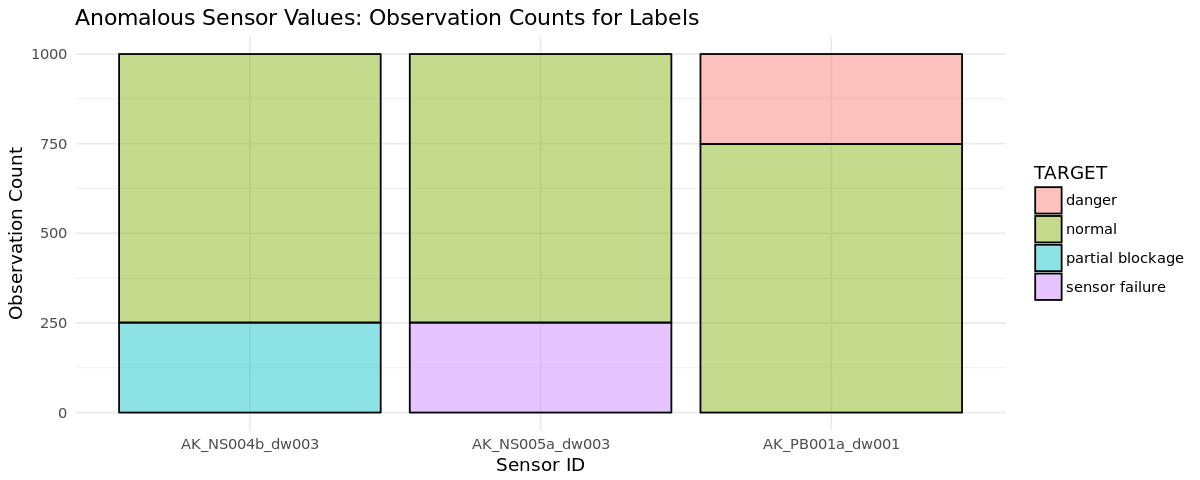

In [12]:
## Look at our observation counts in our training set for each label
options(repr.plot.width=10, repr.plot.height=4)

ggplot(trainingDF, aes(x = SENSOR_ID, fill = TARGET)) + 
    geom_bar(position = 'stack', alpha = 0.45, color = 'black') +
    theme_minimal() +
    labs(title = "Anomalous Sensor Values: Observation Counts for Labels",
        y = "Observation Count", x = "Sensor ID")

To build our final training set, we will select the features that appear to contribute most to the classification, as well as the classification column itself.  This is a first pass at modeling this data and much remains to be explored.  However, these findings are worth sharing so let's do that!

In [13]:
trainingDF <- ungroup(trainingDF) %>% select(TARGET, TEMPERATURE, PSI, GEOPHONE, FLOW_RATE_LFM, ACCELEROMETER)
head(trainingDF)

TARGET,TEMPERATURE,PSI,GEOPHONE,FLOW_RATE_LFM,ACCELEROMETER
normal,216.7163,3267.962,67.80540,0.4712928,7.455832
normal,209.7364,3207.890,69.57746,0.5013222,8.763928
normal,211.7790,3248.935,65.50159,0.6333677,6.601536
normal,216.5584,3225.644,68.29141,0.7491168,8.502031
normal,208.5160,3202.364,69.10690,0.6484336,8.094485
normal,218.2879,3229.241,67.98911,0.4715569,7.128023


This looks like a good table to feed to Watson Machine Learning.  We can move forward to the next step in our project and train a model.

__________

#### Persist Training Data

There are many options to persist the training data.  We could write the file directly from this notebook to a table in DB2, or many other databases.  We could also put the file in our project bucket on COS.  However, for the sake of simplicity and security we will work with another CSV file and upload it to our project from the Assets page. 

_____________________

### Conclusion
To review:  After accessing data from Watson IoT Platform that was streaming into COS via the catalog, we explored sensor data statistically and visually.  This allowed us to identify anomalous, outlying values in the data and track down which particular devices were generating them.  After taking a closer look we labeled the data and discussed various options to persist it.  Now it's time to go train and deploy a predictive model using Watson Machine Learning!

_____________________

<div><br><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png" width = 200 height = 200>
</div><br>